In [1]:
pip install medmnist timm torch torchvision -q


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import AutoAugment, AutoAugmentPolicy
from timm import create_model
import torch.nn as nn
import torch.optim as optim
import os
import requests
import zipfile
from PIL import Image
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt

/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class NumpyDataset(Dataset):
    def __init__(self, images_path, labels_path, transform=None):
        self.images = np.load(images_path)
        self.labels = np.load(labels_path)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        image = (image * 255).astype(np.uint8)
        label = int(label) # int label 1d

        # CHW
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0).repeat(3, 1, 1)
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [4]:
path = '/home/dime/Downloads/Pre-thesis/data/pneumoniamnist_224'

In [5]:
from collections import Counter

def compute_class_counts(labels_path):
    labels = np.load(labels_path).flatten()  
    return dict(Counter(labels))  

In [6]:
def load_datasets(batch_size=32, img_size=224):
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
        transforms.Normalize(mean=[0.5], std=[0.5]),
    ])
    
    train_dataset = NumpyDataset(os.path.join(path, 'train_images.npy'), os.path.join(path, 'train_labels.npy'), transform)
    val_dataset = NumpyDataset(os.path.join(path, 'val_images.npy'), os.path.join(path, 'val_labels.npy'), transform)
    test_dataset = NumpyDataset(os.path.join(path, 'test_images.npy'), os.path.join(path, 'test_labels.npy'), transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


In [7]:
train_class_counts = compute_class_counts(os.path.join(path, 'train_labels.npy'))
val_class_counts = compute_class_counts(os.path.join(path, 'val_labels.npy'))
test_class_counts = compute_class_counts(os.path.join(path, 'test_labels.npy'))

print('Train class counts:', train_class_counts)
print('Val class counts:', val_class_counts)
print('Test class counts:', test_class_counts)

Train class counts: {1: 3494, 0: 1214}
Val class counts: {1: 389, 0: 135}
Test class counts: {1: 390, 0: 234}


In [8]:
class VGG16(nn.Module):
    def __init__(self, num_classes):
        super(VGG16, self).__init__()
        self.model = create_model('vgg16', pretrained=True, num_classes=num_classes)
        
    def forward(self, x):
        return self.model(x)

In [9]:
def plot_metrics(metrics_log):
    epochs = range(1, len(metrics_log["train_loss"]) + 1)

    # Plot loss
    plt.figure()
    plt.plot(epochs, metrics_log["train_loss"], label="Train Loss")
    plt.plot(epochs, metrics_log["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss vs Epochs")
    plt.legend()
    plt.show()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, metrics_log["train_accuracy"], label="Train Accuracy")
    plt.plot(epochs, metrics_log["val_accuracy"], label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Epochs")
    plt.legend()
    plt.show()

    # Plot F1 score
    plt.figure()
    plt.plot(epochs, metrics_log["train_f1"], label="Train F1 Score")
    plt.plot(epochs, metrics_log["val_f1"], label="Validation F1 Score")
    plt.xlabel("Epochs")
    plt.ylabel("F1 Score")
    plt.title("F1 Score vs Epochs")
    plt.legend()
    plt.show()

In [10]:
num_epochs = 10
learning_rate = 0.001

def train_model(model, train_loader, val_loader, device, num_epochs=num_epochs, lr=learning_rate):
    metrics_log = {
        "train_loss": [],
        "train_accuracy": [],
        "train_f1": [],
        "val_loss": [],
        "val_accuracy": [],
        "val_f1": []    
    }

    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    scaler = torch.cuda.amp.GradScaler()

    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        all_labels, all_preds = [], []

        for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

        train_accuracy = accuracy_score(all_labels, all_preds)
        train_f1 = f1_score(all_labels, all_preds, average='weighted')
        train_loss = running_loss / len(train_loader)

        model.eval()
        val_loss = 0.0
        val_labels, val_preds = [], []
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validating"):
                images, labels = images.to(device), labels.to(device)
                with torch.cuda.amp.autocast():
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = outputs.max(1)
                val_labels.extend(labels.cpu().numpy())
                val_preds.extend(predicted.cpu().numpy())

        val_accuracy = accuracy_score(val_labels, val_preds)
        val_f1 = f1_score(val_labels, val_preds, average='weighted')
        val_loss /= len(val_loader)

        metrics_log["train_loss"].append(train_loss)
        metrics_log["train_accuracy"].append(train_accuracy)
        metrics_log["train_f1"].append(train_f1)
        metrics_log["val_loss"].append(val_loss)
        metrics_log["val_accuracy"].append(val_accuracy)
        metrics_log["val_f1"].append(val_f1)

        scheduler.step()

        print(f"Epoch [{epoch+1}/{num_epochs}]:")
        print(f"  Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, F1: {train_f1:.4f}")
        print(f"  Val Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, F1: {val_f1:.4f}")
    
    print(f"  Final Train Loss: {metrics_log['train_loss'][-1]:.4f}")
    print(f"  Final Train Accuracy: {metrics_log['train_accuracy'][-1]:.4f}")
    print(f"  Final Train F1: {metrics_log['train_f1'][-1]:.4f}")
    print(f"  Final Val Loss: {metrics_log['val_loss'][-1]:.4f}")
    print(f"  Final Val Accuracy: {metrics_log['val_accuracy'][-1]:.4f}")
    print(f"  Final Val F1: {metrics_log['val_f1'][-1]:.4f}")
    plot_metrics(metrics_log)
    return metrics_log

Training Epoch 1/10:   0%|          | 0/74 [00:00<?, ?it/s]/tmp/ipykernel_114660/3580189112.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms fro

Epoch [1/10]:
  Train Loss: 1.0797, Accuracy: 0.6958, F1: 0.6305
  Val Loss: 0.5575, Accuracy: 0.7653, F1: 0.7024


Training Epoch 2/10:   0%|          | 0/74 [00:00<?, ?it/s]/tmp/ipykernel_114660/3580189112.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms fro

Epoch [2/10]:
  Train Loss: 0.5621, Accuracy: 0.7532, F1: 0.6869
  Val Loss: 0.5627, Accuracy: 0.7424, F1: 0.6326


Training Epoch 3/10:   0%|          | 0/74 [00:00<?, ?it/s]/tmp/ipykernel_114660/3580189112.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms fro

Epoch [3/10]:
  Train Loss: 0.5395, Accuracy: 0.7657, F1: 0.6922
  Val Loss: 0.4912, Accuracy: 0.7977, F1: 0.7671


Training Epoch 4/10:   0%|          | 0/74 [00:00<?, ?it/s]/tmp/ipykernel_114660/3580189112.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms fro

Epoch [4/10]:
  Train Loss: 0.4973, Accuracy: 0.8035, F1: 0.7688
  Val Loss: 0.5447, Accuracy: 0.7424, F1: 0.6326


Training Epoch 5/10:   0%|          | 0/74 [00:00<?, ?it/s]/tmp/ipykernel_114660/3580189112.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms fro

Epoch [5/10]:
  Train Loss: 0.4951, Accuracy: 0.7959, F1: 0.7571
  Val Loss: 0.5112, Accuracy: 0.7958, F1: 0.7702


Training Epoch 6/10:   0%|          | 0/74 [00:00<?, ?it/s]/tmp/ipykernel_114660/3580189112.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms fro

Epoch [6/10]:
  Train Loss: 0.4635, Accuracy: 0.8195, F1: 0.7939
  Val Loss: 0.4815, Accuracy: 0.7977, F1: 0.7671


Training Epoch 7/10:   0%|          | 0/74 [00:00<?, ?it/s]/tmp/ipykernel_114660/3580189112.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms fro

Epoch [7/10]:
  Train Loss: 0.4719, Accuracy: 0.8112, F1: 0.7849
  Val Loss: 0.4754, Accuracy: 0.7882, F1: 0.7628


Training Epoch 8/10:   0%|          | 0/74 [00:00<?, ?it/s]/tmp/ipykernel_114660/3580189112.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms fro

Epoch [8/10]:
  Train Loss: 0.4646, Accuracy: 0.8150, F1: 0.7898
  Val Loss: 0.4546, Accuracy: 0.8225, F1: 0.8003


Training Epoch 9/10:   0%|          | 0/74 [00:00<?, ?it/s]/tmp/ipykernel_114660/3580189112.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms fro

Epoch [9/10]:
  Train Loss: 0.4595, Accuracy: 0.8161, F1: 0.7934
  Val Loss: 0.4627, Accuracy: 0.8053, F1: 0.7815


Training Epoch 10/10:   0%|          | 0/74 [00:00<?, ?it/s]/tmp/ipykernel_114660/3580189112.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms fr

Epoch [10/10]:
  Train Loss: 0.4627, Accuracy: 0.8112, F1: 0.7871
  Val Loss: 0.4970, Accuracy: 0.7882, F1: 0.7554
  Final Train Loss: 0.4627
  Final Train Accuracy: 0.8112
  Final Train F1: 0.7871
  Final Val Loss: 0.4970
  Final Val Accuracy: 0.7882
  Final Val F1: 0.7554


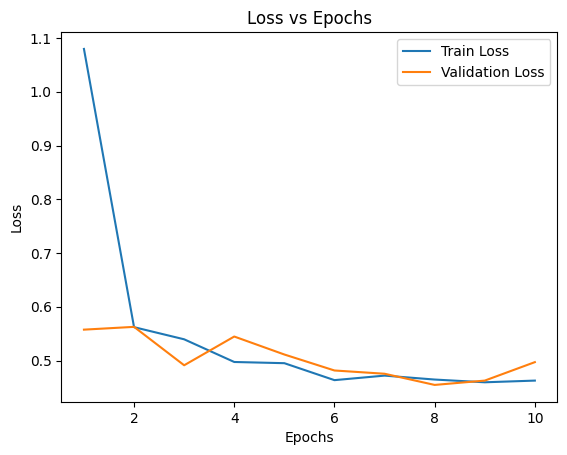

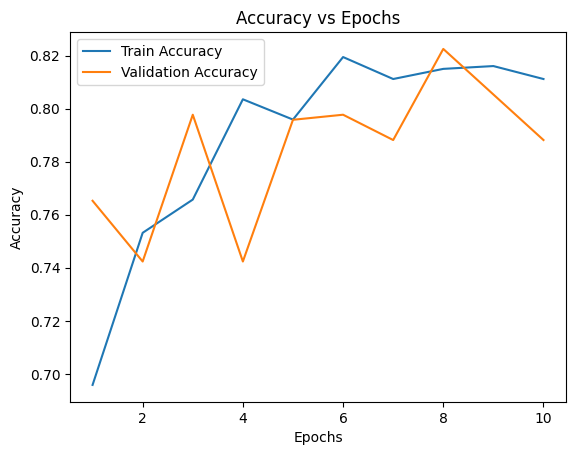

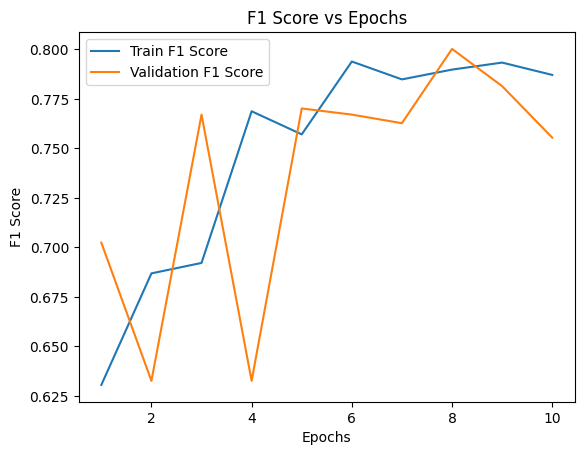

In [11]:
if __name__ == "__main__":
    batch_size = 64
    img_size = 224

    train_loader, val_loader, test_loader = load_datasets(batch_size, img_size)

    num_classes = 7

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = VGG16(num_classes=num_classes)

    train_model(model, train_loader, val_loader, device, num_epochs, learning_rate)

In [12]:
torch.save(model.state_dict(), '/home/dime/Downloads/Pre-thesis/data/pneumoniamnist_224/vgg_full_model.pth')

## 100 images per class 